## Access the new REST-based MODIS web service and perform quality filtering using R
 
*Author: ORNL DAAC*  
*Date: May 4, 2018*  
*Contact for the ORNL DAAC: uso@daac.ornl.gov*

### Keywords: MODIS, web service, R, REST

## Overview

This notebook will explore using the R to access MODIS Land Products through the new (May 2018) REST-based web service hosted by the ORNL DAAC. For a full description and usage examples of the web service, please visit the ORNL DAAC's MODIS microsite:
https://modis.ornl.gov/data/modis_webservice.html

Using the MODIS Web Service users can:

* Retrieve MODIS subsets through command line operations
* Download and integrate subsets directly into client-side workflows
* Download and visualize subsets with customized code 
* ... and much more.

This tutorial will demonstrate how to do the following in R:

* **dates** and **subset** request examples
* build a time series of MOD11A2 land surface temperature from multiple web service subset requests
* perform quality control filtering based on multiple MODIS qc criteria

## Prerequisites: 

R
Librarys: httr, readr, jsonlite, ggplot2, scales  
*Note: Not all libraries required. readr enables conversation of text response into data.frame; jsonlite enables conversion of json response.*

## Tutorial:

In [1]:
# For interaction with the web service
library(httr)
library(readr)
library(jsonlite)

# For plotting
library(ggplot2)
library(scales)

endpoint <- "https://modis.ornl.gov/rst/api/v1/"

### GET Request: dates
***/api/v1/{product}/dates***

The MODIS Web Service has a ten tile limit per request to ensure responsivity of the service and to avoid time outs. The **dates** function returns a list of available dates for the specified coordinate and MODIS product.

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products** function         |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |


Create a list of dates for MOD11A2 for a coordinate in North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **dates** function:

In [2]:
r <- GET("https://modis.ornl.gov/rst/api/v1/MOD11A2/dates?latitude=39.56499&longitude=-121.55527")
dates <- content(r)$dates

# Print the first ten MODIS dates
dates[1:10]

[[1]]
[1] "A2000049"

[[2]]
[1] "A2000057"

[[3]]
[1] "A2000065"

[[4]]
[1] "A2000073"

[[5]]
[1] "A2000081"

[[6]]
[1] "A2000089"

[[7]]
[1] "A2000097"

[[8]]
[1] "A2000105"

[[9]]
[1] "A2000113"

[[10]]
[1] "A2000121"

### GET Request: subset
***/api/v1/{product}/dates***

Returns the subset specified by the input parameters in either json or text/csv format. kmAboveBelow and kmLeftRightight indicate the number of kilometers above and below, left and right of the center pixel of the subset; e.g. for a 500-m product (MOD09A1) 10, 10 will result in a subset with a spatial extent covering 20.5- x 20.5-km.  

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products**                  |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |
| **band**           | band ID as listed by **bands**                                |
| **startDate**      | MODIS start date as listed by **dates** ("AYYYYDOY")          |
| **endDate**        | MODIS end date as listed by **dates** ("AYYYYDOY")            |
| **kmAboveBelow**   | number of kilometers to subset above and below center pixel   |
| **kmLeftRight**    | number of kilometers to subset left and right of center pixel |

Submit a request for the MOD11A2 daytime LST 8-day composite for January 1, 2001 for a 4.5- by 4.5-km area near North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **subset** function:

In [3]:
r <- GET("https://modis.ornl.gov/rst/api/v1/MOD11A2/subset?latitude=39.56499&longitude=-121.55527&band=LST_Day_1km&startDate=A2001001&endDate=A2001001&kmAboveBelow=2&kmLeftRight=2", add_headers(Accept = "text/csv"))
subset <- read_csv(content(r, as="text"), col_names = FALSE)
subset

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
MOD11A2.A2001001.h08v05.006.2015111234608.LST_Day_1km,MOD11A2,A2001001,Lat39.56499Lon-121.55527Samp5Line5,2.015111e+12,14341,14349,14366,14391,14404,...,14285,14294,14293,14375,14364,14353,14301,14271,14350,14270


Note that we have added headers to accept the request response in text/csv format:  
```
GET(URL, add_headers(Accept = "text/csv")
```
The response is read into an R data.frame using the read_csv function from the *readr* library.
```
read_csv(content(r, as="text"), col_names = FALSE)
```

The request response can also be formatted as JSON using the *jsonlite* library that we imported above. No headers need to be submitted with the request:

In [4]:
r <- GET("https://modis.ornl.gov/rst/api/v1/MOD11A2/subset?latitude=39.56499&longitude=-121.55527&band=LST_Day_1km&startDate=A2001001&endDate=A2001001&kmAboveBelow=2&kmLeftRight=2")
toJSON(content(r))

{"band":["LST_Day_1km"],"cellsize":["926.62543305583381"],"header":["https://modis.ornl.gov/rst/rst/api/v1/MOD11A2/subset?latitude=39.56499&longitude=-121.55527&band=LST_Day_1km&startDate=A2001001&endDate=A2001001&kmAboveBelow=2&kmLeftRight=2"],"latitude":[39.565],"longitude":[-121.5553],"ncols":[5],"nrows":[5],"scale":["0.02"],"subset":[{"band":["LST_Day_1km"],"data":[[14341],[14349],[14366],[14391],[14404],[14360],[14354],[14363],[14351],[14344],[14328],[14299],[14270],[14374],[14396],[14285],[14294],[14293],[14375],[14364],[14353],[14301],[14271],[14350],[14270]],"modis_date":["A2001001"],"proc_date":["2015111234608"],"tile":["h08v05"]}],"units":["Kelvin"],"xllcorner":["-10421756.18"],"yllcorner":["4396837.72"]} 

Now you're ready to request a time series of data.

## Build time series from multiple requests

Because of the ten tile limit imposed by the web service, we must submit multiple requests to build a multi-year time series. 

Let's request three years of LST data for a 20.5- x 20.5-km area around the same coordinate in North Table Mountain Ecological Reserve (39.56499, -121.55527). Set up the **subset** input parameters:

In [5]:
lat <- 39.56499 # Input latitude
lon <- -121.55527 # Input longitude
prod <- 'MOD11A2' # MODIS product
data_band <- 'LST_Day_1km' # Daytime LST band name
qc_band <- 'QC_Day' # Daytime QC band name
above_below <- 10 # km above/below
left_right <- 10 # km left/right

**MOD11A2** is generated in 8-day composites for a total of 46 composite periods per calendar year. 

Take three years of dates beginning with A2001001 : 46 \* 3 = 138 dates

In [6]:
dates <- dates[which(dates == 'A2001001'):(which(dates == 'A2001001') + 137)]

We will loop through the *dates* variable in increments of ten and submit requests for both the **daytime LST** (LST_Day_1km) and **daytime QC layers** (QC_Day). This may take several minutes:

In [7]:
# For the sake of readibility, let's create simple function to build request URLs:
requestURL <- function(latitude, longitude, band, start_date, end_date, kmAB, kmLR){
    return(
        paste0(
            endpoint,prod,"/subset?",
            "latitude=",lat,
            "&longitude=",lon,
            "&band=",band,
            "&startDate=",start_date,
            "&endDate=",end_date,
            "&kmAboveBelow=",above_below,
            "&kmLeftRight=",left_right
        )
    )
}

# Initialize response data.frames to store the returned LST and QC data
lstdata <- data.frame()
qcdata <- data.frame()

# Iterate through the list of dates and submit subset requests in increments of 10 dates.
for (dt in seq(from=1,to=(length(dates)-10), by=10)){
    
    # Build LST request URL
    request_url <- requestURL(lat, lon, data_band, dates[dt], dates[dt + 9], above_below, left_right)
    
    # Submit request and append to LST time series
    r <- GET(request_url)
    subset <- fromJSON(toJSON(content(r)))
    lstdata <- rbind(lstdata, subset$subset)
    
    # Build QC request URL
    request_url <- requestURL(lat, lon, qc_band, dates[dt], dates[dt + 9], above_below, left_right)
    
    # Submit request and append to QC time series
    r <- GET(request_url)
    subset <- fromJSON(toJSON(content(r)))
    qcdata <- rbind(qcdata, subset$subset)

}

# We may still have dates left over. Submit requests for the last <=10 dates.
# Build LST request URL
request_url <- requestURL(lat, lon, data_band, dates[dt + 10], tail(dates, n=1), above_below, left_right)

# Submit request and append to LST time series
r <- GET(request_url)
subset <- fromJSON(toJSON(content(r)))
lstdata <- rbind(lstdata, subset$subset)

# Get LST scale factor
scale = as.double(subset$scale)

# Build QC request URL
request_url <- requestURL(lat, lon, qc_band, dates[dt + 10], tail(dates, n=1), above_below, left_right)

# Submit request and append to QC time series
r <- GET(request_url)
subset <- fromJSON(toJSON(content(r)))
qcdata <- rbind(qcdata, subset$subset)

# Get subset row and column counts for data transformation
nrow = as.integer(subset$nrow)
ncol = as.integer(subset$ncol)

**Create LST and QC data.frames**

Convert *modis_date* columns of **lstdata** and **qcdata** to R dates. Then, convert the *data* columns of **lstdata** and **qcdata** to data.frames where rows are timesteps and columns are pixels.

In [8]:
# Change the modis_date columns of lstdata and qcdata into R dates:
lstdata$modis_date <- as.Date(substring(dates, 2), '%Y%j')
qcdata$modis_date <- as.Date(substring(dates, 2), '%Y%j')

# Create separate data.frames for data columns (lstvalues and qcvalues)
lstvalues <- t(as.data.frame(lstdata$data, col.names=lstdata$modis_date, check.names=FALSE))
qcvalues <- t(as.data.frame(qcdata$data, col.names=qcdata$modis_date, check.names=FALSE))

Now that we have the LST and QC time series for our subset area, we can perform the quality filtering.

### Evaluate QC data

In order to filter the pixels with questionable quality from our LST time series, we need to understand the QC bit layer. We will do this using a clever method implemented by [Steve Mosher](https://stevemosher.wordpress.com/2012/12/05/modis-qc-bits/).

Let's start by getting the unique values from the QC subset data.frame:

In [9]:
qcvals <- unique(c(qcvalues))
print(paste('Unique QC values: ', paste(sort(qcvals), collapse=', '), sep = ''), quote = FALSE)

[1] Unique QC values: 0, 2, 17, 65, 81, 97, 145


**MOD11A2** uses 8-bit unsigned integers to indicate the quality of each pixel. See the [MOD11A2](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a2_v006) page of the [MODIS Product Table](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table) for additional resources.

Build a table describing the bits for all possible QC 8-bit integer values (0-255):

In [10]:
# Create empty data.frame with a row for each possible QC integer value and columns for each bit (8bit)
QC_Data <- data.frame(
    Integer_Value = 0:255, Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, 
    Bit1 = NA, Bit0 = NA, Mandatory_QA = NA, Data_Quality = NA, Emiss_Err = NA, LST_Err = NA
)

# Loop through each QC integer and populate the QC bit columns with 0s and 1s
for(i in QC_Data$Integer_Value){
    AsInt <- as.integer(intToBits(i)[1:8])
    QC_Data[i+1,2:9]<- AsInt[8:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==0] <- 'LST GOOD'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==1] <- 'LST Produced,Other Quality'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==0] <- 'No Pixel,clouds'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==1] <- 'No Pixel, Other QA'

QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==0] <- 'Good Data'
QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==1] <- 'Other Quality'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==0] <- 'TBD'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==1] <- 'TBD'

QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==0] <- 'Emiss Error <= .01'
QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==1] <- 'Emiss Err <=.02'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==0] <- 'Emiss Err <=.04'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==1] <- 'Emiss Err > .04'

QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==0] <- 'LST Err <= 1K'
QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==1] <- 'LST Err <= 3K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==0] <- 'LST Err <= 2K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==1] <- 'LST Err > 3K'

The QC table is too large to print. Let's subset the table to include only rows for QC integer values contained within our subset:

In [11]:
QC_Data <- QC_Data[QC_Data$Integer_Value %in% qcvals,]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Error <= .01,LST Err <= 1K
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
17,0,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 1K
65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Error <= .01,LST Err <= 3K
81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 3K
97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.04,LST Err <= 3K
145,1,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 2K


Now we can decide which QC filtering criteria satisfy our needs. In this example, we will filter:  
* Pixels that were not produced due to cloud cover:  **Integer_Value %in% c(2,3)**
* Pixels of 'other quality' that and have an LST error > 2K:  **Bit0 == 1 & Bit1 ==0 & Bit6 == 1**

Subset the QC integer table again to include only rows that represent QC criteria for pixels that we want to filter:

In [12]:
QC_Data <- QC_Data[QC_Data$Bit0 == 1 & QC_Data$Bit1 == 0 & QC_Data$Bit6 != 0 | QC_Data$Integer_Value %in% c(2, 3),]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Error <= .01,LST Err <= 3K
81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 3K
97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.04,LST Err <= 3K


Loop through rows of **lstvalues** and **qcvalues** and filter pixels where:
```
qcvalues %in% QC_Data$Integer_Value
```

In [13]:
filter <- QC_Data$Integer_Value # We will remove these values

for(tstep in seq(1, length(dates), by = 1)){   
    filt <- which(qcvalues[tstep,] %in% filter)
    lstvalues[tstep,filt] <- NA
}

### Plot the LST time series

Now that the LST data is filtered according to our QC criteria, let's prepare the time series for plotting. Apply the scale factor for LST (0.02). We retrieved the scale factor with our last request response (*subset$scale*).

Then, calculate mean, standard deviation, and the percentage of acceptable quality pixels for each timestep in a new data.frame called **lststats**:

In [14]:
lstvalues <- lstvalues*as.numeric(scale) # Apply scale factor

lststats <- data.frame(
    date = lstdata$modis_date, 
    mean = rowMeans(lstvalues, na.rm=TRUE), 
    sd = apply(lstvalues, 1, sd, na.rm = TRUE),
    quality = apply(lstvalues, 1, function(x) sum(!is.na(x))/(nrow*ncol)*100))

# Get min and max of the calculated means
meanMax <- max(lststats$mean, na.rm = TRUE)
meanMin <- min(lststats$mean, na.rm = TRUE)     
# Create simple function to scale the quality values to the mean values for plotting
scaleq <- function(x){((x-0)/(100-0))*(meanMax-meanMin)+meanMin}

Find the 68% confidence intervals and plot:

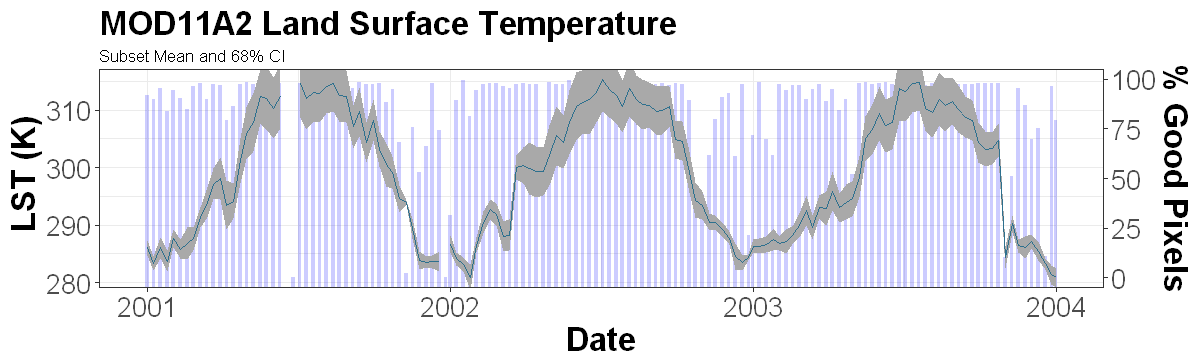

In [15]:
# find the 68% confidence intervals around the mean
y1 <- lststats$mean + lststats$sd 
y2 <- lststats$mean - lststats$sd

plot <- ggplot(lststats) +
  # Data quality
  geom_col(aes(y=scaleq(lststats$quality), x=date), fill= 'blue', alpha = 0.2) +
  scale_y_continuous(limits = c(meanMin, meanMax), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin)/(meanMax - meanMin))*100, name = "% Good Pixels")) +

  # LST mean and sd
  geom_ribbon(aes(ymin=y2, ymax=y1, x=date), fill = 'darkgray') + # draw the shaded area for 68% CI
  geom_line(aes(y=mean, x=date), colour = '#2D708EFF') + # draw the line for the mean value  

  labs(title = 'MOD11A2 Land Surface Temperature', subtitle = 'Subset Mean and 68% CI') +
  ylab(' LST (K)') + # add a y-axis label
  xlab("Date") + # add a x-axis label
  theme_bw() + # set the plot theme
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), 
        axis.title.x = element_text(face="bold", size=20), 
        axis.title.y = element_text(face="bold", size=20), 
        axis.text.x = element_text(size=16), 
        axis.text.y = element_text(size=16)) # set optional theme elements

options(repr.plot.width = 10, repr.plot.height = 3)
plot